Install py-pde library

In [27]:
%pip install py-pde

Note: you may need to restart the kernel to use updated packages.


Generate dataset

In [26]:
from pde import CartesianGrid, ScalarField, solve_poisson_equation
import torch
import numpy as np

num_param_steps = 64
field_values = np.linspace(0,10,num_param_steps)
grid_size = 64

training_input = torch.zeros(num_param_steps, grid_size,2)
training_output = torch.zeros(num_param_steps, grid_size,1)

grid = CartesianGrid([[0, 1]], grid_size, periodic=False)

for index, val in enumerate(field_values):
  field = ScalarField(grid, val)
  result = solve_poisson_equation(field, bc=[{"value": 0}, {"derivative": 1}])
  training_input[index,:,0] = torch.tensor(field.data)
  training_input[index,:,1] = torch.linspace(0,1, grid_size)
  training_output[index,:,0] = torch.tensor(result.data)


In [21]:
import math as m

radius = 3.0
area = m.pi * m.pow(radius, 2)
print(area)

28.274333882308138


In [22]:
import torch
!python --version

!python -m site --user-site
#!pip list -v
torch.__version__


Python 3.7.11
/Users/sebastian/.local/lib/python3.7/site-packages


'1.10.2'

Model definitions copied from https://github.com/zongyi-li/fourier_neural_operator

In [23]:
import torch.nn as nn
import torch.nn.functional as F

################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = F.gelu(x1) + x2

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = F.gelu(x1) + x2

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = F.gelu(x1) + x2

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = F.gelu(x1) + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x


In [24]:
modes = 32
width = 16

epochs = 5000
learning_rate = 1e-4
batch_size = 64

model = FNO1d(modes, width) #.to('cuda')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 1e-3, epochs=epochs, steps_per_epoch= num_param_steps // batch_size)

dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(training_input, training_output), batch_size=batch_size, shuffle=True)


for ep in range(epochs):
  for input, output in dataloader:
    #input, output = input.cuda(), output.cuda()
    optimizer.zero_grad()
    pred_output = model(input)
    loss = torch.nn.functional.mse_loss(pred_output, output)
    loss.backward()
    optimizer.step()
    scheduler.step()
  print("\r",'loss:' + str(loss.detach().cpu().numpy()), end = "")
  


 loss:nan51985

Check output

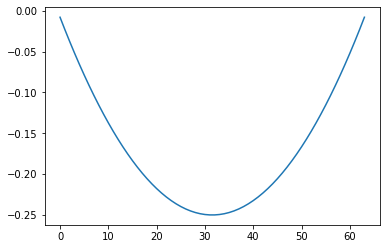

In [25]:
import matplotlib.pyplot as plt

grid_start = 0
grid_end = 1
test_grid_size = 64
field_val = 2

test_field = ScalarField(CartesianGrid([[grid_start, grid_end]], test_grid_size, periodic=False), field_val)
test_result = solve_poisson_equation(test_field, bc=[{"value": 0}, {"derivative": 1}])

model_input = torch.tensor(test_field.data, dtype= torch.float).reshape(1,test_grid_size,1)
model_input = torch.cat((model_input.reshape(1,test_grid_size,1), torch.linspace(grid_start,grid_end, test_grid_size).reshape(1,test_grid_size,1)), dim = -1)
#model_input = model_input.to('cuda')

model_result = model(model_input)

plt.figure()
plt.plot(test_result.data)
plt.plot(model_result.detach().cpu().flatten().numpy())